In [14]:
import numpy as np
from torch import nn
from torchvision import transforms
from torchvision.io import read_image
from torchvision.io import read_image
import pandas as pd
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler
import torch.optim as optim
import torch
import os
import shutil
import random

In [15]:
alexNetTransform = transforms.Compose([
    transforms.Resize((227)),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [19]:
alex_net_train = ImageFolder(root = "./sign_lang/asl_alphabet_train/asl_alphabet_train/",
                         transform=alexNetTransform
                        )


In [20]:
print(len(alex_net_train))

84100


In [21]:
#As seen above the length of the training set is 87000, 3000 images per class, too large for our compute power
#the length of our test set is too small.

#The plan is to reduce the training set and increase the test.

In [22]:
def copy_random_images(source_dir, target_dir, num_images):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for root, dirs, files in os.walk(source_dir):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            
            all_files = os.listdir(dir_path)
            image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        
            selected_files = random.sample(image_files, min(num_images, len(image_files)))
            
            for file_name in selected_files:
                src_path = os.path.join(dir_path, file_name)
                dest_path = os.path.join(target_dir, file_name)
                
                shutil.move(src_path, dest_path)
                print(f"Copied {file_name} to {target_dir}")


source_directory = './sign_lang/asl_alphabet_train/'
target_directory = './sign_lang/asl_alphabet_test/asl_alphabet_test/'
number_of_images = 100 

#copy_random_images(source_directory, target_directory, number_of_images)


In [23]:
#next step is reducing the training set to 500 per class and a total of 14500 training images
import os
import random
from torchvision import datasets

dataset = datasets.ImageFolder('./sign_lang/asl_alphabet_train/asl_alphabet_train/')

#count of each class
class_count = {}
for file in dataset.imgs:
    cls = file[1]
    if cls not in class_count:
        class_count[cls] = 0
    class_count[cls] += 1

n_items_per_class = 500

# Selecting a random subset of images for each class
selected_files = []
for cls, count in class_count.items():
    class_files = [file for file in dataset.imgs if file[1] == cls]
    selected_files.extend(random.sample(class_files, min(n_items_per_class, count)))

selected_dataset = datasets.ImageFolder('./sign_lang/asl_alphabet_train/asl_alphabet_train/', [file[0] for file in selected_files])

In [24]:
selected_dataset = datasets.ImageFolder(
    './sign_lang/asl_alphabet_train/asl_alphabet_train/',
    transform=alexNetTransform,  # Assuming you have a transform defined
    is_valid_file=lambda x: x in [file[0] for file in selected_files]
)

arr = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","del","nothing","space"]
for i in range(29):
    print(f"{arr[i]}: {(selected_dataset.targets).count(i)}")

A: 500
B: 500
C: 500
D: 500
E: 500
F: 500
G: 500
H: 500
I: 500
J: 500
K: 500
L: 500
M: 500
N: 500
O: 500
P: 500
Q: 500
R: 500
S: 500
T: 500
U: 500
V: 500
W: 500
X: 500
Y: 500
Z: 500
del: 500
nothing: 500
space: 500


In [25]:
train_dataloader = DataLoader(selected_dataset, batch_size= 128, shuffle = True)

In [26]:
len(train_dataloader.dataset.targets)

14500

In [27]:
#Training an alexNet architecture
import torch.nn as nn
import torch.nn.functional as F

#AlexNet implementation
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3,96, kernel_size=11, stride=4, padding=0)
        #nn.BatchNorm2d(96)
        self.pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        #nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        #nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        #nn.BatchNorm2d(384)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        #nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.fc1 = nn.Linear(9216, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        #self.fc3 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(4096, 29)
        
        #cnn utilities
        self.norm1 = nn.BatchNorm2d(96)
        self.norm2 = nn.BatchNorm2d(256)
        self.norm3 = nn.BatchNorm2d(384)
        
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.norm1(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.norm2(x)
        x = self.pool1(x)
        
        x = F.relu(self.conv3(x))
        x = self.norm3(x)
        x = F.relu(self.conv4(x))
        x = self.norm3(x)
        
        x = F.relu(self.conv5(x))
        x = self.norm2(x)
        x = self.pool3(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        #x = F.relu(self.fc3(x))
        x = self.fc3(x)
        return x
    
alex_net = AlexNet()


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alex_net.parameters(), lr=0.001, momentum=0.9)

In [29]:
#Training
for epoch in range(12):  

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = alex_net(inputs)
        loss = criterion(outputs, labels)
        print(loss)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Loss: {running_loss/len(train_dataloader)}")

print("training is done my bouy")

tensor(3.4237, grad_fn=<NllLossBackward0>)
tensor(3.4523, grad_fn=<NllLossBackward0>)
tensor(3.4432, grad_fn=<NllLossBackward0>)
tensor(3.4594, grad_fn=<NllLossBackward0>)
tensor(3.3982, grad_fn=<NllLossBackward0>)
tensor(3.4235, grad_fn=<NllLossBackward0>)
tensor(3.3672, grad_fn=<NllLossBackward0>)
tensor(3.3639, grad_fn=<NllLossBackward0>)
tensor(3.4021, grad_fn=<NllLossBackward0>)
tensor(3.3679, grad_fn=<NllLossBackward0>)
tensor(3.3575, grad_fn=<NllLossBackward0>)
tensor(3.4009, grad_fn=<NllLossBackward0>)
tensor(3.3670, grad_fn=<NllLossBackward0>)
tensor(3.3488, grad_fn=<NllLossBackward0>)
tensor(3.3628, grad_fn=<NllLossBackward0>)
tensor(3.3104, grad_fn=<NllLossBackward0>)
tensor(3.3497, grad_fn=<NllLossBackward0>)
tensor(3.2655, grad_fn=<NllLossBackward0>)
tensor(3.2969, grad_fn=<NllLossBackward0>)
tensor(3.3750, grad_fn=<NllLossBackward0>)
tensor(3.3320, grad_fn=<NllLossBackward0>)
tensor(3.2631, grad_fn=<NllLossBackward0>)
tensor(3.2561, grad_fn=<NllLossBackward0>)
tensor(3.27

tensor(1.2270, grad_fn=<NllLossBackward0>)
tensor(1.2007, grad_fn=<NllLossBackward0>)
tensor(1.2161, grad_fn=<NllLossBackward0>)
tensor(1.2696, grad_fn=<NllLossBackward0>)
tensor(1.3185, grad_fn=<NllLossBackward0>)
tensor(1.2937, grad_fn=<NllLossBackward0>)
tensor(1.2802, grad_fn=<NllLossBackward0>)
tensor(1.2643, grad_fn=<NllLossBackward0>)
tensor(1.2139, grad_fn=<NllLossBackward0>)
tensor(1.2353, grad_fn=<NllLossBackward0>)
tensor(1.1971, grad_fn=<NllLossBackward0>)
tensor(1.2921, grad_fn=<NllLossBackward0>)
tensor(1.2575, grad_fn=<NllLossBackward0>)
tensor(1.1720, grad_fn=<NllLossBackward0>)
tensor(1.0451, grad_fn=<NllLossBackward0>)
tensor(1.1882, grad_fn=<NllLossBackward0>)
tensor(1.2122, grad_fn=<NllLossBackward0>)
tensor(1.2010, grad_fn=<NllLossBackward0>)
tensor(0.9742, grad_fn=<NllLossBackward0>)
tensor(1.1863, grad_fn=<NllLossBackward0>)
tensor(1.2115, grad_fn=<NllLossBackward0>)
tensor(1.1149, grad_fn=<NllLossBackward0>)
tensor(1.4081, grad_fn=<NllLossBackward0>)
tensor(1.24

tensor(0.5215, grad_fn=<NllLossBackward0>)
tensor(0.5153, grad_fn=<NllLossBackward0>)
tensor(0.4034, grad_fn=<NllLossBackward0>)
tensor(0.4177, grad_fn=<NllLossBackward0>)
tensor(0.4773, grad_fn=<NllLossBackward0>)
tensor(0.3301, grad_fn=<NllLossBackward0>)
tensor(0.4901, grad_fn=<NllLossBackward0>)
tensor(0.4032, grad_fn=<NllLossBackward0>)
tensor(0.5007, grad_fn=<NllLossBackward0>)
tensor(0.3884, grad_fn=<NllLossBackward0>)
tensor(0.4788, grad_fn=<NllLossBackward0>)
tensor(0.3914, grad_fn=<NllLossBackward0>)
tensor(0.4111, grad_fn=<NllLossBackward0>)
tensor(0.4235, grad_fn=<NllLossBackward0>)
tensor(0.4377, grad_fn=<NllLossBackward0>)
tensor(0.4359, grad_fn=<NllLossBackward0>)
tensor(0.4067, grad_fn=<NllLossBackward0>)
tensor(0.3678, grad_fn=<NllLossBackward0>)
tensor(0.4756, grad_fn=<NllLossBackward0>)
tensor(0.4100, grad_fn=<NllLossBackward0>)
tensor(0.3350, grad_fn=<NllLossBackward0>)
tensor(0.3892, grad_fn=<NllLossBackward0>)
tensor(0.3863, grad_fn=<NllLossBackward0>)
tensor(0.42

Loss: 0.2404593092046286
tensor(0.1813, grad_fn=<NllLossBackward0>)
tensor(0.1438, grad_fn=<NllLossBackward0>)
tensor(0.3207, grad_fn=<NllLossBackward0>)
tensor(0.1929, grad_fn=<NllLossBackward0>)
tensor(0.1810, grad_fn=<NllLossBackward0>)
tensor(0.1638, grad_fn=<NllLossBackward0>)
tensor(0.2185, grad_fn=<NllLossBackward0>)
tensor(0.1800, grad_fn=<NllLossBackward0>)
tensor(0.1634, grad_fn=<NllLossBackward0>)
tensor(0.1189, grad_fn=<NllLossBackward0>)
tensor(0.2270, grad_fn=<NllLossBackward0>)
tensor(0.1513, grad_fn=<NllLossBackward0>)
tensor(0.1289, grad_fn=<NllLossBackward0>)
tensor(0.2074, grad_fn=<NllLossBackward0>)
tensor(0.1148, grad_fn=<NllLossBackward0>)
tensor(0.1564, grad_fn=<NllLossBackward0>)
tensor(0.1466, grad_fn=<NllLossBackward0>)
tensor(0.1359, grad_fn=<NllLossBackward0>)
tensor(0.1357, grad_fn=<NllLossBackward0>)
tensor(0.1913, grad_fn=<NllLossBackward0>)
tensor(0.1559, grad_fn=<NllLossBackward0>)
tensor(0.1769, grad_fn=<NllLossBackward0>)
tensor(0.1249, grad_fn=<NllLo

tensor(0.0744, grad_fn=<NllLossBackward0>)
tensor(0.0917, grad_fn=<NllLossBackward0>)
tensor(0.0599, grad_fn=<NllLossBackward0>)
tensor(0.0847, grad_fn=<NllLossBackward0>)
tensor(0.1068, grad_fn=<NllLossBackward0>)
tensor(0.0865, grad_fn=<NllLossBackward0>)
tensor(0.1110, grad_fn=<NllLossBackward0>)
tensor(0.0951, grad_fn=<NllLossBackward0>)
tensor(0.1037, grad_fn=<NllLossBackward0>)
tensor(0.0754, grad_fn=<NllLossBackward0>)
tensor(0.1367, grad_fn=<NllLossBackward0>)
tensor(0.0984, grad_fn=<NllLossBackward0>)
tensor(0.1155, grad_fn=<NllLossBackward0>)
tensor(0.0953, grad_fn=<NllLossBackward0>)
tensor(0.0944, grad_fn=<NllLossBackward0>)
tensor(0.0532, grad_fn=<NllLossBackward0>)
tensor(0.0865, grad_fn=<NllLossBackward0>)
tensor(0.0722, grad_fn=<NllLossBackward0>)
tensor(0.0828, grad_fn=<NllLossBackward0>)
tensor(0.1185, grad_fn=<NllLossBackward0>)
tensor(0.0677, grad_fn=<NllLossBackward0>)
tensor(0.0644, grad_fn=<NllLossBackward0>)
tensor(0.0873, grad_fn=<NllLossBackward0>)
tensor(0.07

tensor(0.0958, grad_fn=<NllLossBackward0>)
tensor(0.0404, grad_fn=<NllLossBackward0>)
tensor(0.0613, grad_fn=<NllLossBackward0>)
tensor(0.0544, grad_fn=<NllLossBackward0>)
tensor(0.0410, grad_fn=<NllLossBackward0>)
tensor(0.0384, grad_fn=<NllLossBackward0>)
tensor(0.0851, grad_fn=<NllLossBackward0>)
tensor(0.0369, grad_fn=<NllLossBackward0>)
tensor(0.0638, grad_fn=<NllLossBackward0>)
tensor(0.0801, grad_fn=<NllLossBackward0>)
tensor(0.0432, grad_fn=<NllLossBackward0>)
tensor(0.0644, grad_fn=<NllLossBackward0>)
tensor(0.0595, grad_fn=<NllLossBackward0>)
tensor(0.0678, grad_fn=<NllLossBackward0>)
tensor(0.0557, grad_fn=<NllLossBackward0>)
tensor(0.0296, grad_fn=<NllLossBackward0>)
tensor(0.0769, grad_fn=<NllLossBackward0>)
tensor(0.0542, grad_fn=<NllLossBackward0>)
tensor(0.0392, grad_fn=<NllLossBackward0>)
tensor(0.0537, grad_fn=<NllLossBackward0>)
tensor(0.0412, grad_fn=<NllLossBackward0>)
tensor(0.0443, grad_fn=<NllLossBackward0>)
tensor(0.0454, grad_fn=<NllLossBackward0>)
tensor(0.02

Loss: 0.03467974663107542
tensor(0.0311, grad_fn=<NllLossBackward0>)
tensor(0.0319, grad_fn=<NllLossBackward0>)
tensor(0.0152, grad_fn=<NllLossBackward0>)
tensor(0.0472, grad_fn=<NllLossBackward0>)
tensor(0.1827, grad_fn=<NllLossBackward0>)
tensor(0.0274, grad_fn=<NllLossBackward0>)
tensor(0.0206, grad_fn=<NllLossBackward0>)
tensor(0.0372, grad_fn=<NllLossBackward0>)
tensor(0.0366, grad_fn=<NllLossBackward0>)
tensor(0.0243, grad_fn=<NllLossBackward0>)
tensor(0.0239, grad_fn=<NllLossBackward0>)
tensor(0.0413, grad_fn=<NllLossBackward0>)
tensor(0.0171, grad_fn=<NllLossBackward0>)
tensor(0.0322, grad_fn=<NllLossBackward0>)
tensor(0.0694, grad_fn=<NllLossBackward0>)
tensor(0.0331, grad_fn=<NllLossBackward0>)
tensor(0.0268, grad_fn=<NllLossBackward0>)
tensor(0.0286, grad_fn=<NllLossBackward0>)
tensor(0.0346, grad_fn=<NllLossBackward0>)
tensor(0.0370, grad_fn=<NllLossBackward0>)
tensor(0.0408, grad_fn=<NllLossBackward0>)
tensor(0.0352, grad_fn=<NllLossBackward0>)
tensor(0.0280, grad_fn=<NllL

tensor(0.0275, grad_fn=<NllLossBackward0>)
tensor(0.0216, grad_fn=<NllLossBackward0>)
tensor(0.0272, grad_fn=<NllLossBackward0>)
tensor(0.0075, grad_fn=<NllLossBackward0>)
tensor(0.0124, grad_fn=<NllLossBackward0>)
tensor(0.0359, grad_fn=<NllLossBackward0>)
tensor(0.0523, grad_fn=<NllLossBackward0>)
tensor(0.0165, grad_fn=<NllLossBackward0>)
tensor(0.0281, grad_fn=<NllLossBackward0>)
tensor(0.0245, grad_fn=<NllLossBackward0>)
tensor(0.0112, grad_fn=<NllLossBackward0>)
tensor(0.0313, grad_fn=<NllLossBackward0>)
tensor(0.0256, grad_fn=<NllLossBackward0>)
tensor(0.0195, grad_fn=<NllLossBackward0>)
tensor(0.0294, grad_fn=<NllLossBackward0>)
tensor(0.0268, grad_fn=<NllLossBackward0>)
tensor(0.0183, grad_fn=<NllLossBackward0>)
tensor(0.0214, grad_fn=<NllLossBackward0>)
tensor(0.0073, grad_fn=<NllLossBackward0>)
tensor(0.0185, grad_fn=<NllLossBackward0>)
tensor(0.0167, grad_fn=<NllLossBackward0>)
tensor(0.0114, grad_fn=<NllLossBackward0>)
tensor(0.0240, grad_fn=<NllLossBackward0>)
tensor(0.02

In [30]:
#Saving the trained model
SAVED_MODEL_PATH = "./updated_alex_net_sign.pth"
torch.save(alex_net.state_dict(), SAVED_MODEL_PATH)

In [31]:
#test dataloader
test_data_alex = ImageFolder(root = "./sign_lang/asl_alphabet_test/",
                            transform=alexNetTransform
                                         )

In [32]:

test_loader = train_dataloader = DataLoader(test_data_alex)

In [33]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [51]:

dir = os.listdir("./sign_lang/asl_alphabet_test/asl_alphabet_test/" )
alph = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
target_classes = []
for name in dir:
    if name[0] in alph:
        target_classes.append(alph.index(name[0]))
    elif "del" in name:
        target_classes.append(27)
    elif "nothing" in name:
        target_classes.append(28)
    elif "space" in name:
        target_classes.append(29)



In [140]:
target_classes = []
for i in range(30):
    for x in range(100):
        target_classes.append(i)

In [53]:
transformer = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])

predicted_targets = []
for i in range(2900):
    #img = train_data[7003][0]
    img = test_loader.dataset[i][0]
    #plt.show(img.T)
    alex_net.eval()
    with torch.no_grad():
        image_tensor = transformer(img)
        image_tensor.unsqueeze_(0)
        outputs = alex_net(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_targets.append(predicted[0].item())
        #print(predicted[0])
        #plt.imshow(test_loader.dataset[i][0].T)
        #plt.show()

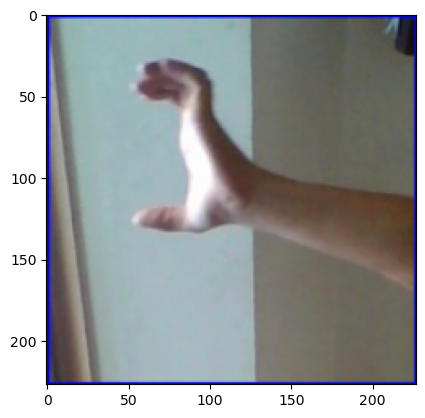

In [136]:
plt.imshow(test_loader.dataset[2850][0].T)
#predicted_targets[400]

In [142]:
def predict_image_label(neural_net, img):
    transformer = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
    #img = train_data[7003][0]
    neural_net.eval()
    with torch.no_grad():
        image_tensor = transformer(img)
        image_tensor.unsqueeze_(0)
        outputs = neural_net(image_tensor)
        _, predicted = torch.max(outputs, 1)
        print(predicted)
#predict_image_label(alex_net, "./del1.jpg")

In [144]:
correct = 0
for i in range(len(predicted_targets)):
    if predicted_targets[i] == target_classes[i]:
        correct +=1
print(f"The score is {(correct/len(predicted_targets))*100}%")

The score is 74.93103448275862%


In [145]:
#loss function
loss_values = [2.935, 1.543, 0.778, 0.433, 0.240, 0.144, 0.090, 0.066, 0.056,0.035, 0.031, 0.027]

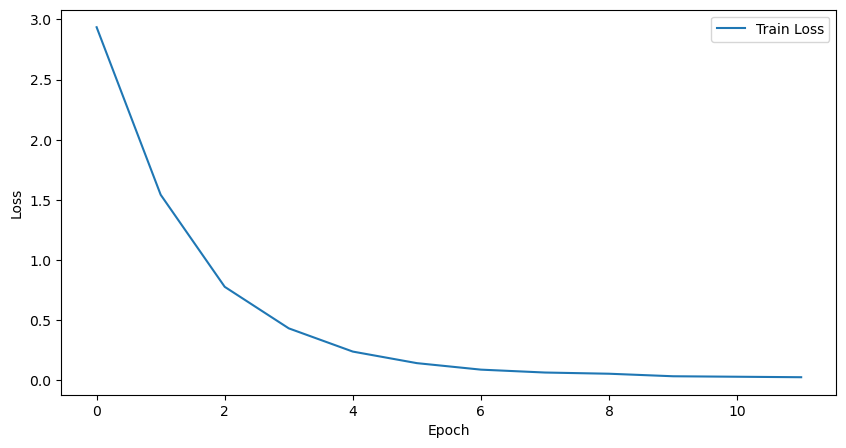

In [147]:
plt.figure(figsize=(10, 5))
plt.plot(range(12),loss_values, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [158]:
import torch
import pytorch_visualization as pv
pv.visualize(alex_net, filename="model_architecture")

ModuleNotFoundError: No module named 'pytorch_visualization'

In [160]:
import graphviz
dot = graphviz.Digraph()

def add_node(dot, node, name):
    dot.node(name, label=node.__class__.__name__)

def add_edge(dot, node1, node2):
    dot.edge(node1.__class__.__name__, node2.__class__.__name__)

def visualize_model(model, dot):
    for name, module in model.named_modules():
        add_node(dot, module, name)
        if hasattr(module, 'weight'):
            add_edge(dot, module, module.weight)
        if hasattr(module, 'bias'):
            add_edge(dot, module, module.bias)

visualize_model(alex_net, dot)

# Render the graph to an image file
dot.render('model_architecture.gv', view=True)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
from torchviz import make_dot

make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")